<a href="https://colab.research.google.com/github/nikkernoodle/shark-id/blob/models/Efficientnet_enhanced_model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [58]:
#check tensorflow versions
!pip freeze | grep tensorflow

tensorflow==2.12.0
tensorflow-datasets==4.9.2
tensorflow-estimator==2.12.0
tensorflow-gcs-config==2.12.0
tensorflow-hub==0.13.0
tensorflow-io-gcs-filesystem==0.32.0
tensorflow-metadata==1.13.1
tensorflow-probability==0.20.1


In [59]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [60]:
from tensorflow.keras import layers, models, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from sklearn.metrics import accuracy_score, balanced_accuracy_score


# PREPROCESSING

In [61]:
def load_sharks_data(loading_method):
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/shark-datasets/sharks'
    elif loading_method == 'direct':
        data_path = '../raw_data/sharks/'
    classes = {'basking': 0, 'blue': 1, 'hammerhead': 2, 'mako': 3, 'sand tiger': 4, 'tiger': 5, 'white' : 6,
               'blacktip': 7 , 'bull': 8, 'lemon':9 , 'nurse': 10, 'thresher': 11, 'whale': 12, 'whitetip': 13}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl))]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((224, 224))
                image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.RandomState(seed=42).permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [63]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_sharks_data("colab")

100%|██████████| 125/125 [00:04<00:00, 25.01it/s]


In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [64]:
# import pickle

# X_train, y_train, X_val, y_val, X_test, y_test, num_classes

# # SAVE FILE
# file_X_train = open('X_train.pickle', 'w')
# pickle.dump(X_train, file_X_train)

# file_X_test = open('X_test.pickle', 'w')
# pickle.dump(X_test, file_X_test)

# file_X_val = open('X_val.pickle', 'w')
# pickle.dump(X_val, file_X_val)

# file_y_train = open('y_train.pickle', 'w')
# pickle.dump(y_train, file_y_train)

# file_y_test = open('y_test.pickle', 'w')
# pickle.dump(y_test, file_y_test)

# file_y_val = open('y_val.pickle', 'w')
# pickle.dump(y_val, file_y_val)

# # LOAD FILE
# file_X_train = open('X_train.pickle', 'r')
# object = pickle.load(file_X_train)

# file_X_test = open('X_test.pickle', 'r')
# object = pickle.load(file_X_test)

# file_X_val = open('X_val.pickle', 'r')
# object = pickle.load(file_X_val)

# file_y_train = open('y_train.pickle', 'r')
# object = pickle.load(file_y_train)

# file_y_test = open('y_test.pickle', 'r')
# object = pickle.load(file_y_test)

# file_y_val = open('X_val.pickle', 'r')
# object = pickle.load(file_y_val)

# MODEL

## Define model

In [65]:
def load_model():

    model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

    return model


In [66]:
model = load_model()
model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_7 (Normalization  (None, 224, 224, 3)  7          ['rescaling_14[0][0]']           
 )                                                                                                
                                                                                     

In [67]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [68]:
model = set_nontrainable_layers(model)
model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_7 (Normalization  (None, 224, 224, 3)  7          ['rescaling_14[0][0]']           
 )                                                                                                
                                                                                     

### Actually build the model

In [69]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer1 = layers.Dense(500, activation='relu')
    dropout_layer1 = layers.Dropout(0.3)
    dense_layer2 = layers.Dense(400, activation='relu')
    dropout_layer2 = layers.Dropout(0.3)
    dense_layer3 = layers.Dense(300, activation='relu')
    dropout_layer3 = layers.Dropout(0.3)
    prediction_layer = layers.Dense(14, activation='softmax')
#creating dense layer 1 (changed from 50 to 500), dense layer 2 (400) and dense layer 3 (300) and dropout layers

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        dropout_layer1,
        dense_layer2,
        dropout_layer2,
        dense_layer3,
        dropout_layer3,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [70]:
model = add_last_layers(model)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_7 (Flatten)         (None, 68992)             0         
                                                                 
 dense_28 (Dense)            (None, 500)               34496500  
                                                                 
 dropout_21 (Dropout)        (None, 500)               0         
                                                                 
 dense_29 (Dense)            (None, 400)               200400    
                                                                 
 dropout_22 (Dropout)        (None, 400)               0         
                                                                 
 dense_30 (Dense)            (None, 300)              

## Compile EfficientnetB2 + layers

In [71]:
def build_model():

    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  weighted_metrics=['accuracy'])

    return model


## Fit the model

In [72]:
model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_8 (Flatten)         (None, 68992)             0         
                                                                 
 dense_32 (Dense)            (None, 500)               34496500  
                                                                 
 dropout_24 (Dropout)        (None, 500)               0         
                                                                 
 dense_33 (Dense)            (None, 400)               200400    
                                                                 
 dropout_25 (Dropout)        (None, 400)               0         
                                                                 
 dense_34 (Dense)            (None, 300)              

In [73]:
from tensorflow.random import set_seed

In [74]:
set_seed(42)
model = build_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 20,
                   verbose = 1,
                   restore_best_weights = True)
#patience changes from 5 to 20
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16,
                    callbacks=[es])
#patience changes from 50 to 100
#batch_size changed from 16 to 32

Epoch 1/100
62/62 [==============================] - 19s 128ms/step - loss: 2.7079 - accuracy: 0.1914 - val_loss: 1.8127 - val_accuracy: 0.4337
Epoch 2/100
62/62 [==============================] - 5s 75ms/step - loss: 1.9565 - accuracy: 0.3564 - val_loss: 1.5312 - val_accuracy: 0.5243
Epoch 3/100
62/62 [==============================] - 5s 80ms/step - loss: 1.7041 - accuracy: 0.4552 - val_loss: 1.3869 - val_accuracy: 0.5858
Epoch 4/100
62/62 [==============================] - 5s 83ms/step - loss: 1.3246 - accuracy: 0.5519 - val_loss: 1.2344 - val_accuracy: 0.6149
Epoch 5/100
62/62 [==============================] - 5s 76ms/step - loss: 1.1334 - accuracy: 0.6212 - val_loss: 1.1820 - val_accuracy: 0.6117
Epoch 6/100
62/62 [==============================] - 5s 81ms/step - loss: 1.0052 - accuracy: 0.6527 - val_loss: 1.0882 - val_accuracy: 0.6667
Epoch 7/100
62/62 [==============================] - 5s 78ms/step - loss: 0.8009 - accuracy: 0.7373 - val_loss: 1.0725 - val_accuracy: 0.6505
Epoc

### Plot accuracy

In [75]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

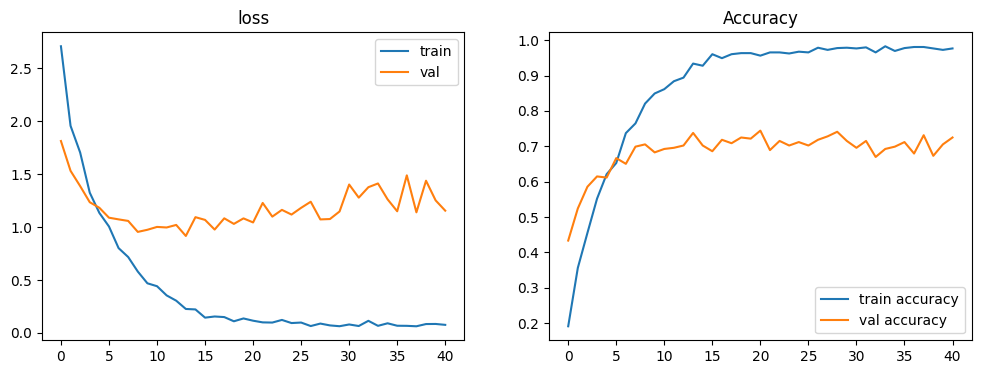

In [76]:
plot_history(history)

In [77]:
#overall accuarcy

res_vgg = model.evaluate(X_test, y_test)

test_accuracy_vgg = res_vgg[-1]


print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

# print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')


9/9 [==============================] - 1s 82ms/step - loss: 1.1484 - accuracy: 0.7132
test_accuracy_vgg = 71.0 %
Chance level: 7.1%


In [78]:
predictions = model.predict(X_test)

9/9 [==============================] - 3s 92ms/step


In [79]:
y_pred = []

for pred in predictions:
  y_pred.append(np.argmax(pred))

In [80]:
y_test_argmax = []
for test in y_test:
  y_test_argmax.append(np.argmax(test))

### Classification Report for each class and overall

#### Create accuracy metric

In [81]:
# Return macro accuracy
accuracy = accuracy_score(y_test_argmax, y_pred)

# Return weighted accuracy
accuracy_bal = balanced_accuracy_score(y_test_argmax, y_pred)

accuracy, accuracy_bal

(0.7131782945736435, 0.7173790369417304)

In [82]:
from sklearn.metrics import classification_report
from sklearn import datasets, svm, metrics

In [87]:
#classification report

labels=['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

report = classification_report(y_test_argmax, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

     basking       1.00      0.88      0.93        16
        blue       0.62      0.76      0.68        17
  hammerhead       0.75      0.82      0.78        22
        mako       1.00      0.81      0.89        21
  sand tiger       0.48      0.67      0.56        15
       tiger       0.92      0.63      0.75        19
       white       0.67      0.89      0.76        18
    blacktip       0.50      0.79      0.61        14
        bull       0.38      0.29      0.33        17
       lemon       0.45      0.43      0.44        21
       nurse       0.92      0.69      0.79        16
    thresher       0.96      0.82      0.88        28
       whale       0.72      1.00      0.84        13
    whitetip       0.80      0.57      0.67        21

    accuracy                           0.71       258
   macro avg       0.73      0.72      0.71       258
weighted avg       0.74      0.71      0.72       258



In [88]:
#classification report
##note that this also ranks accuracy, weight avg and macroavg, so these can be ignored (and taken from the table above)

report = classification_report(y_test_argmax, y_pred, target_names=labels, output_dict=True)

# Convert the report to a pandas DataFrame
df = pd.DataFrame(report).transpose()
df = df.sort_values(by='f1-score', ascending=False)
df.reset_index(inplace=True)
df

,index,precision,recall,f1-score,support
0,basking,1.000000,0.875000,0.933333,16.000000
1,mako,1.000000,0.809524,0.894737,21.000000
2,thresher,0.958333,0.821429,0.884615,28.000000
3,whale,0.722222,1.000000,0.838710,13.000000
4,nurse,0.916667,0.687500,0.785714,16.000000
5,hammerhead,0.750000,0.818182,0.782609,22.000000
6,white,0.666667,0.888889,0.761905,18.000000
7,tiger,0.923077,0.631579,0.750000,19.000000
8,weighted avg,0.741793,0.713178,0.715330,258.000000
9,accuracy,0.713178,0.713178,0.713178,0.713178


### Confusion Matrix for class analysis

In [85]:
cm = confusion_matrix(y_test_argmax, y_pred)

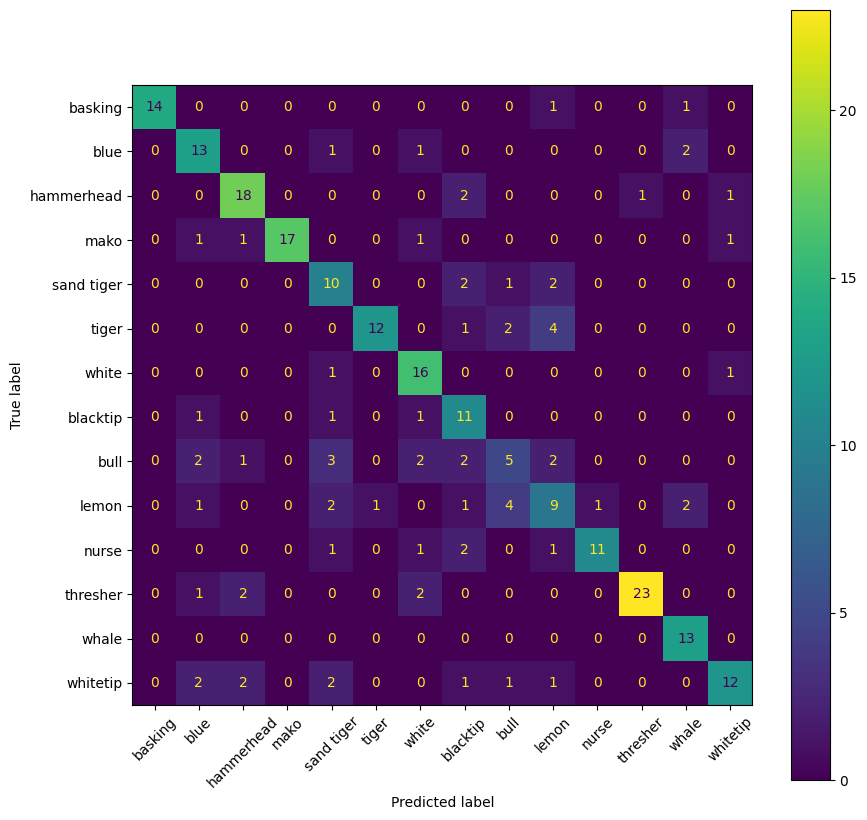

In [86]:
shark_labels = ['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=shark_labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
ax.set_xticklabels(shark_labels, rotation=45)

plt.show()